# Run Data Bias Analysis with SageMaker Clarify (Pre-Training)

## Using SageMaker Processing Jobs

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize SageMaker Session
sess = sagemaker.Session()

# Use your S3 bucket instead of default
bucket = "cardiovale-solutions-datascience-pipeline"

# Ensure correct IAM Role
try:
    role = sagemaker.get_execution_role()  # Works in SageMaker Studio
except:
    role = "arn:aws:iam::<YOUR_ACCOUNT_ID>:role/service-role/AmazonSageMaker-ExecutionRole"

# Get AWS Region
region = boto3.Session().region_name

# Initialize SageMaker & AWS Clients
sm = boto3.client("sagemaker", region_name=region)  # SageMaker client
s3 = boto3.client("s3", region_name=region)  # S3 client
athena = boto3.client("athena", region_name=region)  # Athena client (if needed)

# Print to verify
print(f"Using S3 Bucket: {bucket}")
print(f"Using IAM Role: {role}")
print(f"AWS Region: {region}")


/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Using S3 Bucket: cardiovale-solutions-datascience-pipeline
Using IAM Role: arn:aws:iam::424808199142:role/LabRole
AWS Region: us-east-1


# Get Data from S3

In [2]:
!aws s3 ls s3://cardiovale-solutions-datascience-pipeline/raw-data/

                           PRE cardio_train/
                           PRE cardio_train_cleaned/
                           PRE parquet/
                           PRE quitline_services/


In [3]:
# Define S3 Data Paths
cardio_s3_uri = "s3://cardiovale-solutions-datascience-pipeline/raw-data/cardio_train.csv"
quitline_s3_uri = "s3://cardiovale-solutions-datascience-pipeline/raw-data/Quitline___Services_Available___Medications_-_2010_To_Present_20250306.csv"

# Define Local Storage Directory
local_data_dir = "/home/sagemaker-user/ads-508-team/data/"

# Print Paths for Verification
print("Cardio Data S3 URI:", cardio_s3_uri)
print("Quitline Data S3 URI:", quitline_s3_uri)

# Download Data from S3 to Local
!aws s3 cp {cardio_s3_uri} {local_data_dir}
!aws s3 cp {quitline_s3_uri} {local_data_dir}

# Load Data into Pandas
import pandas as pd

cardio_df = pd.read_csv(f"{local_data_dir}/cardio_train.csv", delimiter=";")
quitline_df = pd.read_csv(f"{local_data_dir}/Quitline___Services_Available___Medications_-_2010_To_Present_20250306.csv", delimiter=",")

# Display Data Samples
print("\nCardio Dataset Sample:")
print(cardio_df.head())

print("\nQuitline Dataset Sample:")
print(quitline_df.head())


Cardio Data S3 URI: s3://cardiovale-solutions-datascience-pipeline/raw-data/cardio_train.csv
Quitline Data S3 URI: s3://cardiovale-solutions-datascience-pipeline/raw-data/Quitline___Services_Available___Medications_-_2010_To_Present_20250306.csv
fatal error: An error occurred (404) when calling the HeadObject operation: Key "raw-data/cardio_train.csv" does not exist
fatal error: An error occurred (404) when calling the HeadObject operation: Key "raw-data/Quitline___Services_Available___Medications_-_2010_To_Present_20250306.csv" does not exist

Cardio Dataset Sample:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     1

In [4]:
data = pd.read_csv("../data/cardio_train.csv")
data.head()

,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0,0;18393;2;168;62.0;110;80;1;1;0;0;1;0
1,1;20228;1;156;85.0;140;90;3;1;0;0;1;1
2,2;18857;1;165;64.0;130;70;3;1;0;0;0;1
3,3;17623;2;169;82.0;150;100;1;1;0;0;1;1
4,4;17474;1;156;56.0;100;60;1;1;0;0;0;0


In [5]:
data.shape

(70000, 1)

### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. 

[04/05/25 21:06:18] INFO     Using categorical units to plot a list of strings that are all         ]8;id=873738;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=299434;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=567406;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=150821;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

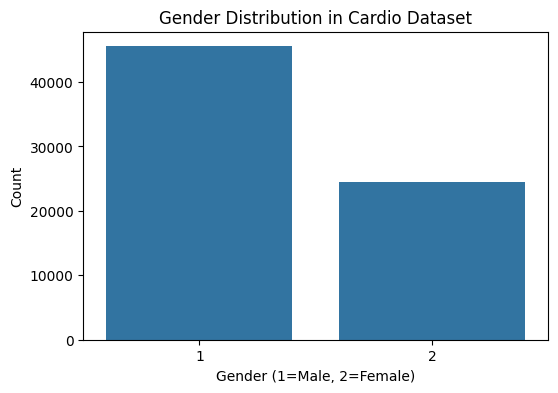

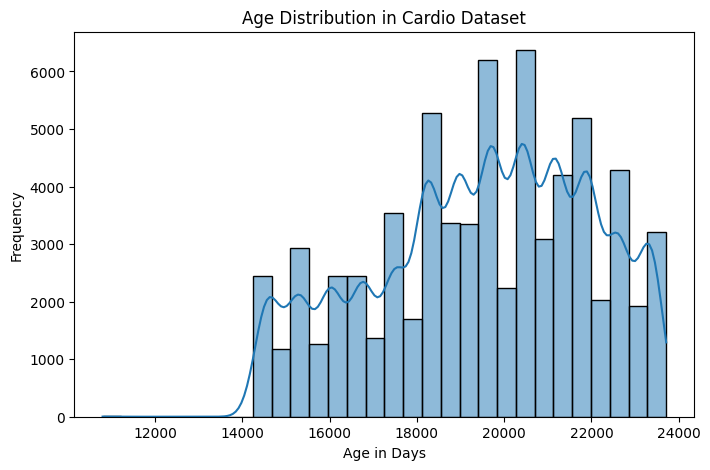

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=327200;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=794027;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=23953;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=484353;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

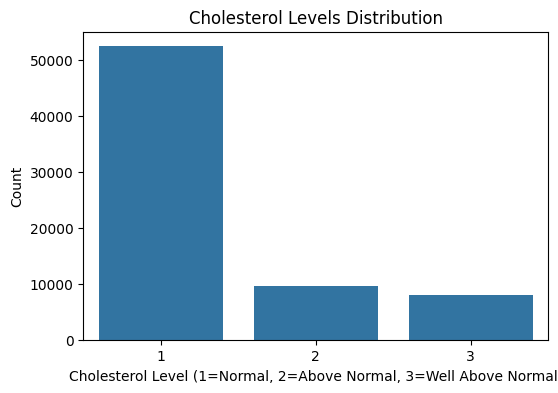

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Analyze Bias in Gender Representation
# -----------------------------
plt.figure(figsize=(6, 4))
sns.countplot(x="gender", data=cardio_df)
plt.title("Gender Distribution in Cardio Dataset")
plt.xlabel("Gender (1=Male, 2=Female)")
plt.ylabel("Count")
plt.show()

# -----------------------------
# 2. Check Age Distribution
# -----------------------------
plt.figure(figsize=(8, 5))
sns.histplot(cardio_df["age"], bins=30, kde=True)
plt.title("Age Distribution in Cardio Dataset")
plt.xlabel("Age in Days")
plt.ylabel("Frequency")
plt.show()

# -----------------------------
# 3. Bias in Cholesterol Levels
# -----------------------------
plt.figure(figsize=(6, 4))
sns.countplot(x="cholesterol", data=cardio_df)
plt.title("Cholesterol Levels Distribution")
plt.xlabel("Cholesterol Level (1=Normal, 2=Above Normal, 3=Well Above Normal)")
plt.ylabel("Count")
plt.show()


# Detecting Bias with Amazon SageMaker Clarify

SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.

In [7]:
from sagemaker import clarify

# Explicitly define the instance type to avoid the warning
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.m5.xlarge",  # Explicitly setting the instance type
    sagemaker_session=sess
)

print("SageMaker Clarify Processor Configured Successfully!")


[04/05/25 21:06:19] INFO     Ignoring unnecessary instance type: None.                            ]8;id=564024;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=284007;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

SageMaker Clarify Processor Configured Successfully!


# Pre-training Bias
Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and hep you understand what societal biases the data may reflect.

Computing pre-training bias metrics does not require a trained model.

## Writing DataConfig
A `DataConfig` object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

In [8]:
# Convert semicolon (;) to comma (,) before saving
cardio_df.to_csv(f"{local_data_dir}/cardio_train_fixed.csv", index=False, sep=",")  
cardio_s3_uri = "s3://cardiovale-solutions-datascience-pipeline/raw-data/cardio_train_fixed.csv"


In [9]:
!aws s3 cp /home/sagemaker-user/ads-508-team/data/cardio_train_fixed.csv s3://cardiovale-solutions-datascience-pipeline/raw-data/


upload: ../data/cardio_train_fixed.csv to s3://cardiovale-solutions-datascience-pipeline/raw-data/cardio_train_fixed.csv


In [10]:
!aws s3 ls s3://cardiovale-solutions-datascience-pipeline/raw-data/


                           PRE cardio_train/
                           PRE cardio_train_cleaned/
                           PRE parquet/
                           PRE quitline_services/
2025-04-05 21:06:20    2941524 cardio_train_fixed.csv


In [11]:
# Define Bias Report Output Path
bias_report_output_path = "s3://{}/clarify".format(bucket)

# Define Bias Data Config
bias_data_config = clarify.DataConfig(
    s3_data_input_path=cardio_s3_uri,  # FIX: Use cardio_s3_uri instead of undefined variable
    s3_output_path=bias_report_output_path,
    label="cardio",  # Ensure this matches the column name in your dataset
    headers=["id", "age", "gender", "height", "weight", "ap_hi", "ap_lo", 
             "cholesterol", "gluc", "smoke", "alco", "active", "cardio"], 
    dataset_type="text/csv"
)

print("Bias Data Config Updated Successfully!")



Bias Data Config Updated Successfully!


## Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star rating==5`, `product_category` is the sensitive column, and `Gift Card` is the sensitive value.

In [12]:
from sagemaker import clarify

# Define BiasConfig for Cardio Dataset
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],  # Assuming "1" means having cardiovascular disease
    facet_name="gender",  # Sensitive column (e.g., gender is often used in bias analysis)
    facet_values_or_threshold=[1],  # Assuming "1" represents Male
)

print("Bias Config Updated Successfully!")


Bias Config Updated Successfully!


## Detect Bias with a SageMaker Processing Job and Clarify

In [13]:
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],  # Statistical bias detection methods
    wait=True,  # Set to True to monitor execution
    logs=True   # Enable logs to track job status
)

print("Bias Detection Job Submitted Successfully!")


[04/05/25 21:06:21] INFO     Analysis Config: {'dataset_type': 'text/csv', 'headers': ['id', 'age', ]8;id=347039;file:///opt/conda/lib/python3.11/site-packages/sagemaker/clarify.py\clarify.py]8;;\:]8;id=371116;file:///opt/conda/lib/python3.11/site-packages/sagemaker/clarify.py#1987\1987]8;;\
                             'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',                
                             'smoke', 'alco', 'active', 'cardio'], 'label': 'cardio',                              
                             'label_values_or_threshold': [1], 'facet': [{'name_or_index':                         
                             'gender', 'value_or_threshold': [1]}], 'methods': {'report': {'name':                 
                             'report', 'title': 'Analysis Report'}, 'pre_training_bias':                           
                             {'methods': ['CI', 'DPL', 'KL', 'JS', 'LP', 'TVD', 'KS']}}}                           

                    INFO     Creating processing-job with name                                      ]8;id=746012;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=459518;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1575\1575]8;;\
                             Clarify-Pretraining-Bias-2025-04-05-21-06-21-025                                      

..................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
We are not in a supported iso region, /bin/sh exiting gracefully with no changes.
INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.data_loader_util:Analysis config path: /opt/ml/processing/input/config/analysis_config.json
INFO:analyzer.data_loading.data_loader_util:Analysis result path: /opt/ml/processing/output
INFO:analyzer.data_loading.data_loader_util:This host is algo-1.
INFO:analyzer.data_loading.data_loader_util:This host is the leader.
INFO:analyzer.data_loading.data_loader_util:Number of hosts in the cluster is 1.
INFO:sagemaker-clarify-processing:Running Python / Pandas based analyzer.
INFO:analyzer.data_loading.data_loader_factory:Dataset type: text/csv uri: /opt/ml/processing/input/data
INFO:sagemaker-clarify

In [14]:
run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name

'Clarify-Pretraining-Bias-2025-04-05-21-06-21-025'

In [15]:
from IPython.core.display import display, HTML

# Generate the SageMaker Processing Job link dynamically
sagemaker_processing_job_url = f"https://console.aws.amazon.com/sagemaker/home?region={region}#/processing-jobs/{run_pre_training_bias_processing_job_name}"

# Display an interactive link to the SageMaker Processing Job
display(
    HTML(
        f'<b>Review <a target="blank" href="{sagemaker_processing_job_url}">Processing Job</a></b>'
    )
)


/tmp/ipykernel_6814/1650809260.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [16]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

/tmp/ipykernel_6814/3205137871.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [17]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

/tmp/ipykernel_6814/2240746175.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [18]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://cardiovale-solutions-datascience-pipeline/raw-data/cardio_train_fixed.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://cardiovale-solutions-datascience-pipeline/clarify/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://cardiovale-solutions-datascience-pipeline/clarify', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-2025-04-05-21-06-21-025', 'Processi

In [19]:
running_processor.wait(logs=False)

!

# Download Report From S3
The class-imbalance metric should match the value calculated for the unbalanced dataset using the open source version above.

In [20]:
!aws s3 ls $bias_report_output_path/

2025-04-05 21:09:51       1945 analysis.json
2025-04-05 21:06:22        433 analysis_config.json
2025-04-05 21:09:51     515756 report.html
2025-04-05 21:09:51     243342 report.ipynb
2025-04-05 21:09:51     253117 report.pdf


In [21]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

download: s3://cardiovale-solutions-datascience-pipeline/clarify/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://cardiovale-solutions-datascience-pipeline/clarify/analysis.json to generated_bias_report/analysis.json
download: s3://cardiovale-solutions-datascience-pipeline/clarify/report.html to generated_bias_report/report.html
download: s3://cardiovale-solutions-datascience-pipeline/clarify/report.pdf to generated_bias_report/report.pdf
download: s3://cardiovale-solutions-datascience-pipeline/clarify/report.ipynb to generated_bias_report/report.ipynb


In [22]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

/tmp/ipykernel_6814/2239962916.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Release Resources

In [23]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [24]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>